# AUC-ROC Comparison

Training data will be used to create a binary target variable: Serious Injury vs Everything Else (Slight Injury / Fatal Injury).

In [145]:
import warnings
warnings.filterwarnings('ignore')

In [146]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [147]:
# Import custom functions
%run ../custom/jc-functions.ipynb

## Prepare Dataset

In [148]:
# Import training dataset 
dataset = Path('../dataset')
df = pd.read_csv(dataset/'accidents_clean_train.csv')
df.head()

,Area_accident_occured,Types_of_Junction,Light_conditions,Number_of_vehicles_involved,Number_of_casualties,Cause_of_accident,Day_of_week,Sex_of_driver,Age_band_of_driver,Accident_severity
0,Residential areas,No junction,Daylight,2,2,Moving Backward,Monday,Male,18-30,Slight Injury
1,Office areas,No junction,Daylight,2,2,Overtaking,Monday,Male,31-50,Slight Injury
2,Recreational areas,No junction,Daylight,2,2,Changing lane to the left,Monday,Male,18-30,Serious Injury
3,Office areas,Y Shape,Darkness - lights lit,2,2,Changing lane to the right,Sunday,Male,18-30,Slight Injury
4,Industrial areas,Y Shape,Darkness - lights lit,2,2,Overtaking,Sunday,Male,18-30,Slight Injury


In [149]:
# Get feature columns
columns = df.columns.tolist()
print(columns)

features = ['Area_accident_occured', 'Types_of_Junction', 'Light_conditions', 'Number_of_vehicles_involved', 'Number_of_casualties', 'Cause_of_accident', 'Day_of_week', 'Sex_of_driver', 'Age_band_of_driver']

target = 'Accident_severity'

['Area_accident_occured', 'Types_of_Junction', 'Light_conditions', 'Number_of_vehicles_involved', 'Number_of_casualties', 'Cause_of_accident', 'Day_of_week', 'Sex_of_driver', 'Age_band_of_driver', 'Accident_severity']


### Training dataset

In [150]:
# Convert to categorical
X = df[features]
X = pd.get_dummies(X, drop_first=True)
X.head()

,Number_of_vehicles_involved,Number_of_casualties,Area_accident_occured_ Recreational areas,Area_accident_occured_ Church areas,Area_accident_occured_ Hospital areas,Area_accident_occured_ Industrial areas,Area_accident_occured_ Outside rural areas,Area_accident_occured_Office areas,Area_accident_occured_Other,Area_accident_occured_Recreational areas,...,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Sex_of_driver_Male,Sex_of_driver_Unknown,Age_band_of_driver_31-50,Age_band_of_driver_Over 51,Age_band_of_driver_Under 18,Age_band_of_driver_Unknown
0,2,2,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,2,2,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,True,False,False,False
2,2,2,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,2,2,False,False,False,False,False,True,False,False,...,True,False,False,False,True,False,False,False,False,False
4,2,2,False,False,False,True,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False


In [151]:
# Create binary target classification for AUC-ROC
df['Accident_serious'] = df[target].map(
    {'Serious Injury': 0}
    ).fillna(1).astype(int)

df.head()

,Area_accident_occured,Types_of_Junction,Light_conditions,Number_of_vehicles_involved,Number_of_casualties,Cause_of_accident,Day_of_week,Sex_of_driver,Age_band_of_driver,Accident_severity,Accident_serious
0,Residential areas,No junction,Daylight,2,2,Moving Backward,Monday,Male,18-30,Slight Injury,1
1,Office areas,No junction,Daylight,2,2,Overtaking,Monday,Male,31-50,Slight Injury,1
2,Recreational areas,No junction,Daylight,2,2,Changing lane to the left,Monday,Male,18-30,Serious Injury,0
3,Office areas,Y Shape,Darkness - lights lit,2,2,Changing lane to the right,Sunday,Male,18-30,Slight Injury,1
4,Industrial areas,Y Shape,Darkness - lights lit,2,2,Overtaking,Sunday,Male,18-30,Slight Injury,1


In [152]:
y = df[target]
y_serious = df['Accident_serious']

### Resample test data

In [153]:
# Resample data due to class imbalance
oversample = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X, y_serious)
# Check distribution
print('Before resampling: ')
print(y_serious.value_counts())
print('\n')
print('After resampling: ')
print(y_resampled.value_counts())

# Split testing data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.3,
                                                    random_state=42)

Before resampling: 
Accident_serious
1    7164
0    1046
Name: count, dtype: int64


After resampling: 
Accident_serious
1    7164
0    7164
Name: count, dtype: int64


### Custom functions

In [154]:
def model_report(test, pred):
    print("Accuracy: ", accuracy_score(test, pred))
    cm = confusion_matrix(test, pred)
    print("Confusion Matrix:\n", multiclass_cm_metrics(cm))
    print("Classification Report:\n", classification_report(test, pred))

def cross_scores(score):
    print("Cross-validation scores: ", score)
    print("Average score: ", score.mean())

# Models

For all models, classification 0 is the target class 'Serious injury'. 

## Naïve Bayes

In [155]:
nb_model = CategoricalNB().fit(X_train, y_train)

## Decision Tree

In [156]:
dt_model = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

## k-Nearest Neighbors

In [157]:
param_grid = {'n_neighbors': range(1, 50)}
knn_mapped = KNeighborsClassifier()
grid_search_mapped = GridSearchCV(knn_mapped, param_grid, cv=5, scoring='accuracy')
grid_search_mapped.fit(X_train, y_train)
knn_model = grid_search_mapped.best_estimator_

## Logistic Regression

In [158]:
logreg_model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

## Random Forest

In [159]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)

## Neural Network

In [160]:
def create_model(optimizer='adam', activation='relu', dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation=activation))
    model.add(Dropout(dropout_rate))
    # model.add(Dense(y_train.shape[1], activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Create model
nn_model = create_model()
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Ensure target variables are in correct format
X_train_flt = X_train.astype('float32')
X_test_flt = X_test.astype('float32')
y_train_flt = y_train.astype('float32')
y_test_flt = y_test.astype('float32')
# Train model
nn_model.fit(X_train_flt, y_train_flt, epochs=50, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# AUC-ROC Curve

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


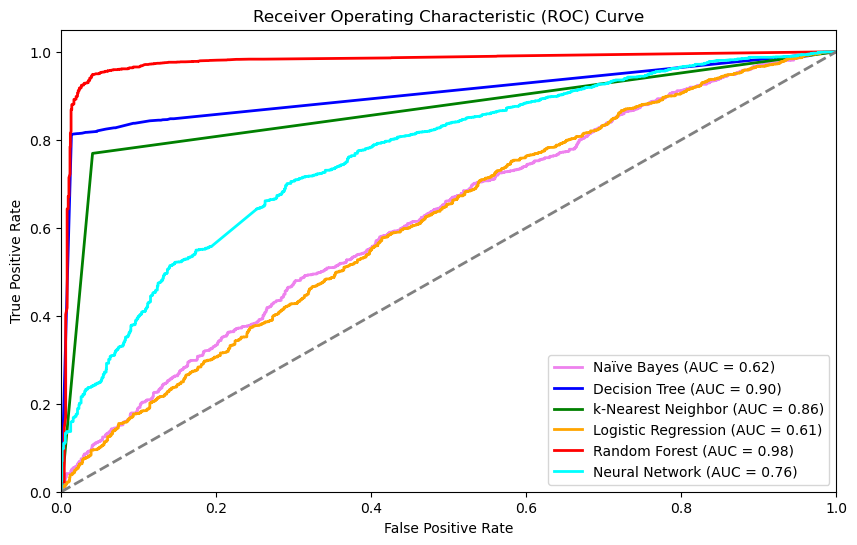

In [161]:
# Predict probabilities for test set
y_probs_nb = nb_model.predict_proba(X_test)[:, 1]
y_probs_dt = dt_model.predict_proba(X_test)[:, 1]
y_probs_knn = knn_model.predict_proba(X_test)[:, 1]
y_probs_lr = logreg_model.predict_proba(X_test)[:, 1]
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]
y_probs_nn = nn_model.predict(X_test_flt)[:, 0]

# Calculate the ROC curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_probs_nb)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_probs_dt)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_probs_knn)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
fpr_nn, tpr_nn, _ = roc_curve(y_test_flt, y_probs_nn)

# Calculate the AUC (Area Under the Curve) for each model
auc_nb = roc_auc_score(y_test, y_probs_nb)
auc_dt = roc_auc_score(y_test, y_probs_dt)
auc_knn = roc_auc_score(y_test, y_probs_knn)
auc_lr = roc_auc_score(y_test, y_probs_lr)
auc_rf = roc_auc_score(y_test, y_probs_rf)
auc_nn = roc_auc_score(y_test_flt, y_probs_nn)

# Plot the ROC curves
plt.figure(figsize=(10, 6))

# Naïve Bayes
plt.plot(fpr_nb, tpr_nb,
         color='violet', lw=2,
         label=f'Naïve Bayes (AUC = {auc_nb:.2f})') 
# Decision Tree
plt.plot(fpr_dt, tpr_dt,
         color='blue', lw=2,
         label=f'Decision Tree (AUC = {auc_dt:.2f})') 
# k-Nearest Neighbor
plt.plot(fpr_knn, tpr_knn,
         color='green', lw=2,
         label=f'k-Nearest Neighbor (AUC = {auc_knn:.2f})') 
# Logistic Regression
plt.plot(fpr_lr, tpr_lr,
         color='orange', lw=2,
         label=f'Logistic Regression (AUC = {auc_lr:.2f})') 
# Random Forest
plt.plot(fpr_rf, tpr_rf,
         color='red', lw=2,
         label=f'Random Forest (AUC = {auc_rf:.2f})') 
# Neural Network
plt.plot(fpr_nn, tpr_nn,
         color='cyan', lw=2,
         label=f'Neural Network (AUC = {auc_nn:.2f})') 
# Reference line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
